Pares encontrados: 8
000_seg_003.png: pixeles=[7507, 1079, 2428, 286], dispersion=[14.146590232849121, 47.07040023803711, 0.0, 161.6995391845703]


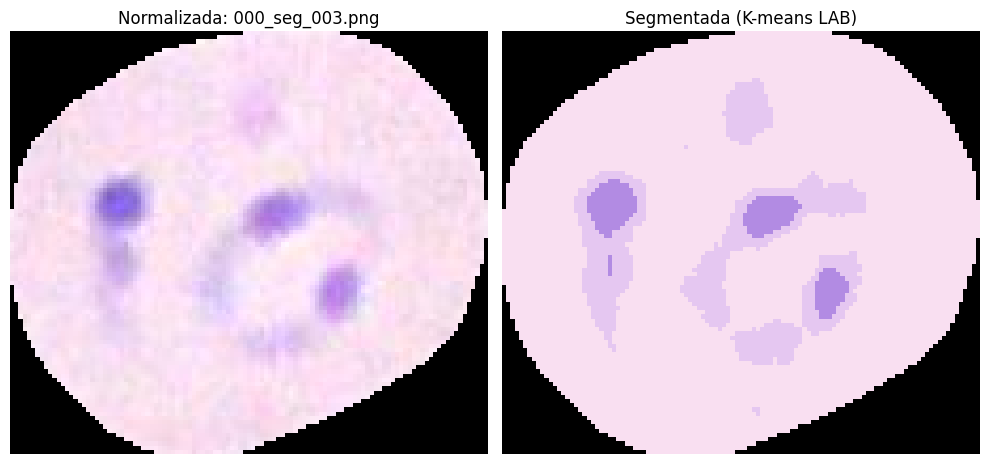

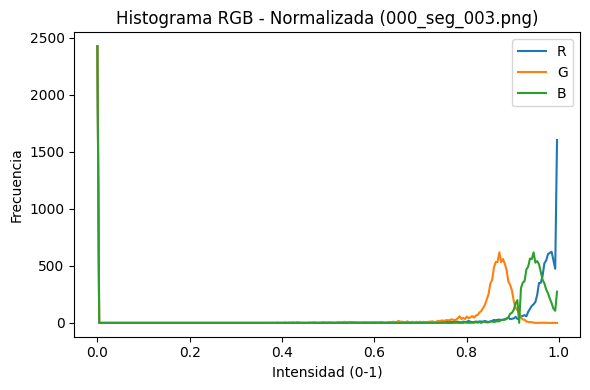

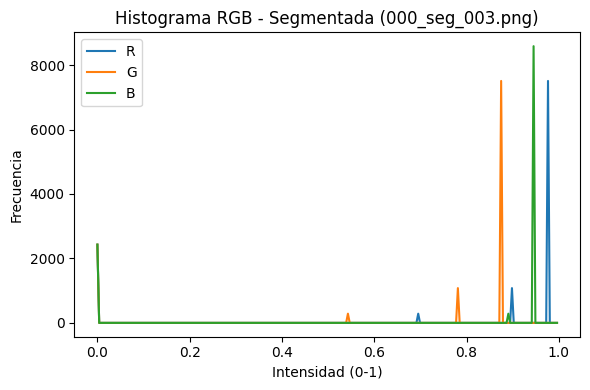

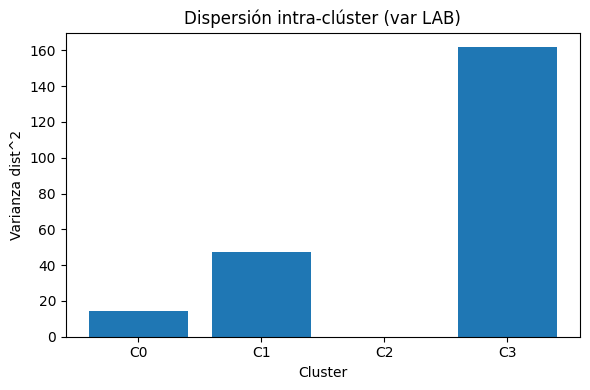

000_seg_004.png: pixeles=[630, 147, 2794, 6879], dispersion=[42.07808303833008, 64.81684112548828, 0.0, 13.624305725097656]


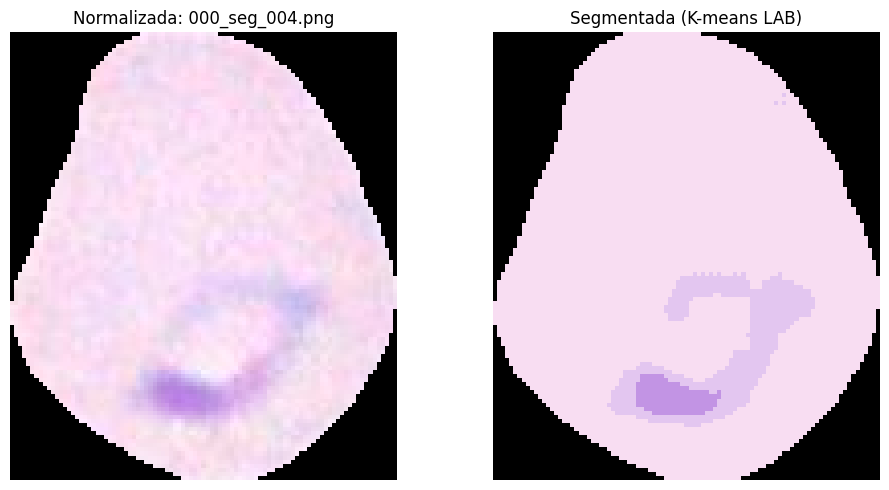

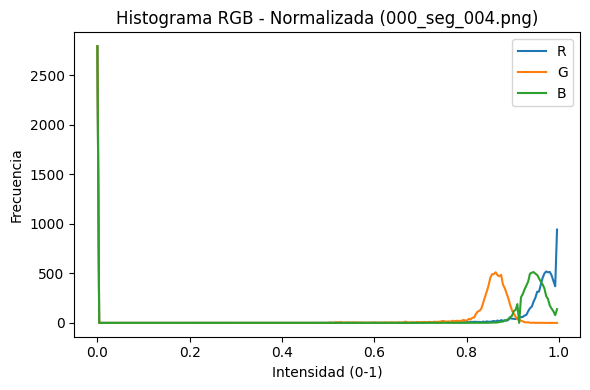

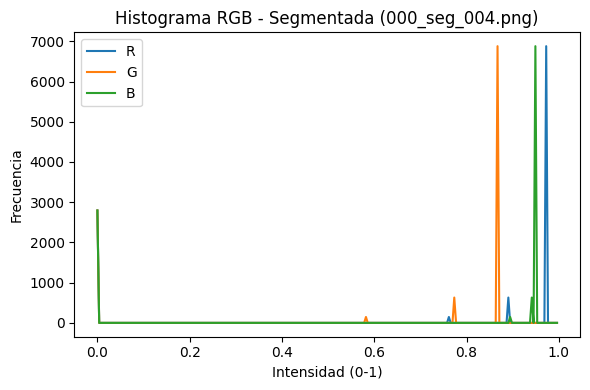

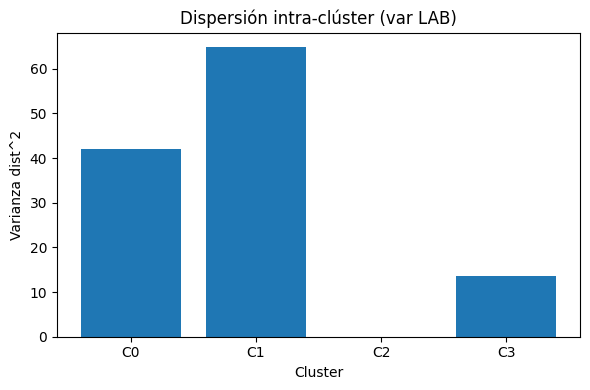

000_seg_000.png: pixeles=[827, 2000, 4869, 1907], dispersion=[71.76589965820312, 0.0, 25.12633514404297, 43.82479476928711]


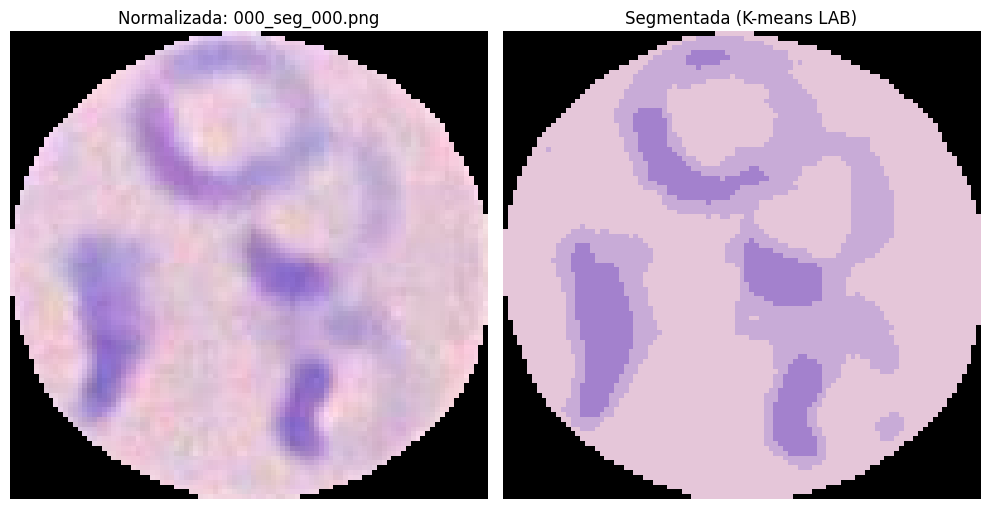

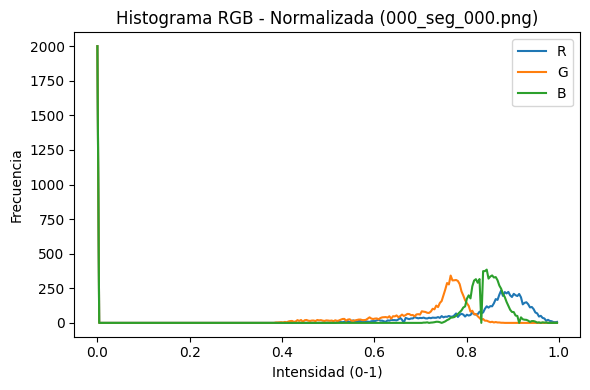

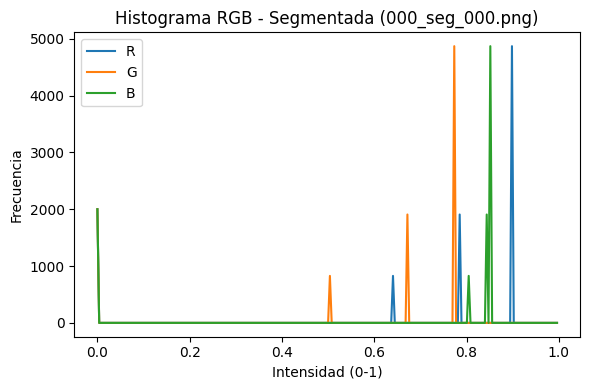

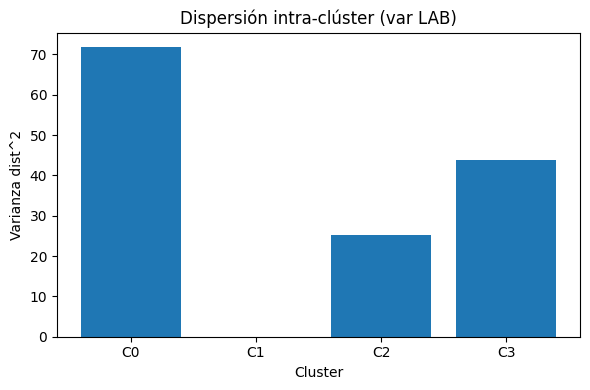

000_seg_001.png: pixeles=[2011, 5142, 434, 2381], dispersion=[19.62025260925293, 12.226176261901855, 75.41999053955078, 0.0]


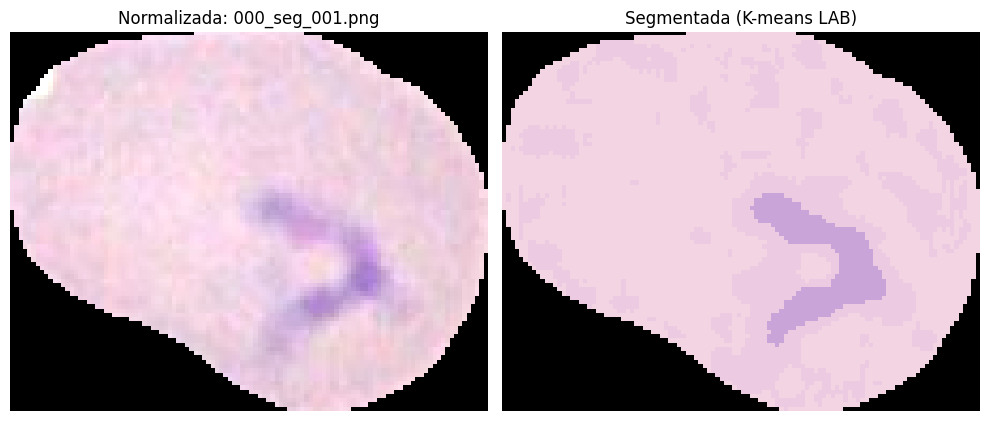

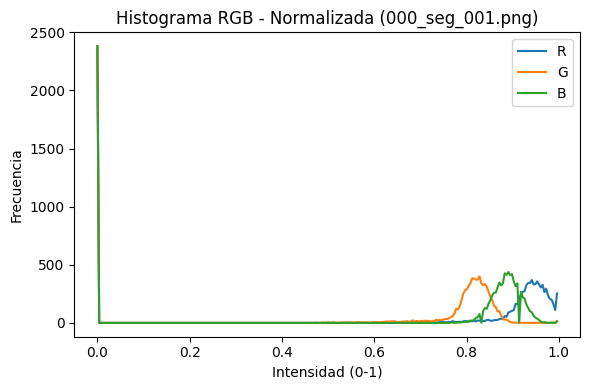

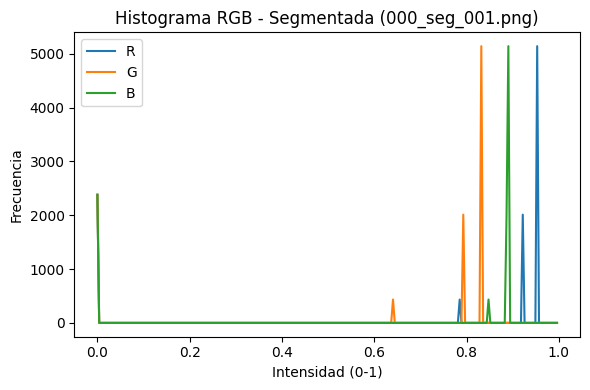

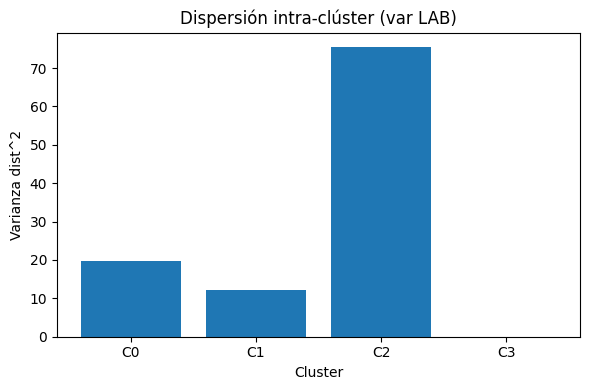

000_seg_007.png: pixeles=[6195, 751, 157, 2896], dispersion=[13.928147315979004, 60.22389602661133, 142.39093017578125, 0.0]


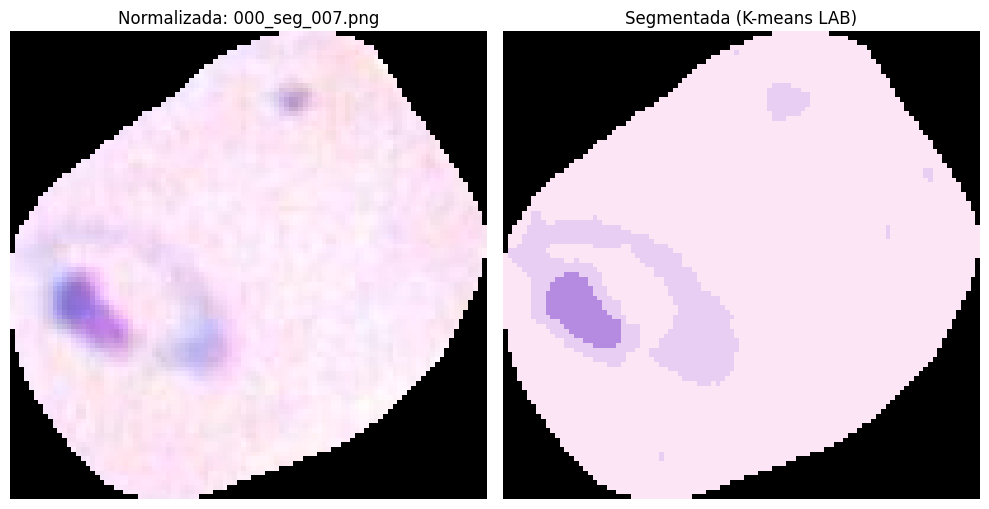

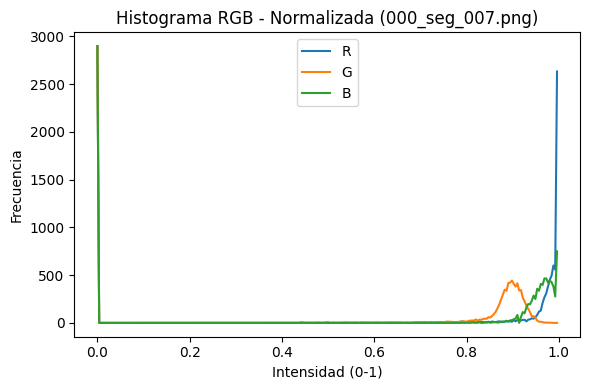

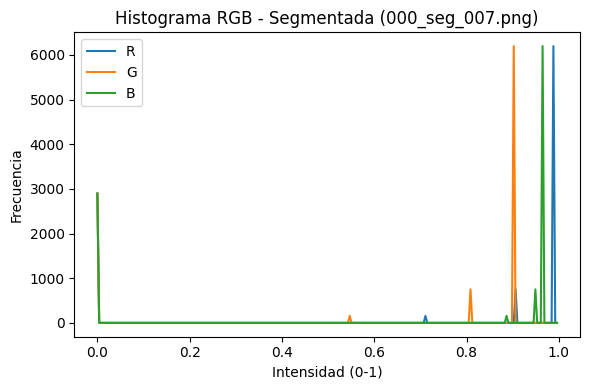

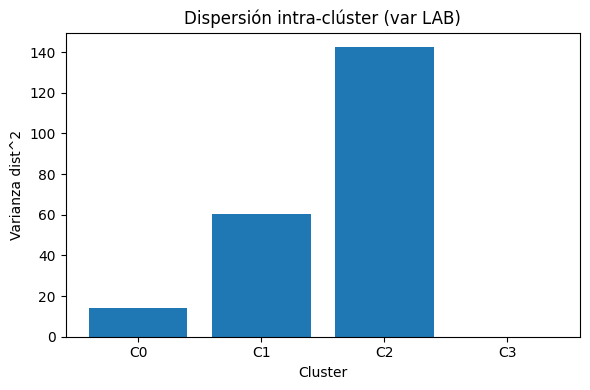

000_seg_006.png: pixeles=[105, 7076, 2111, 311], dispersion=[133.77142333984375, 13.078880310058594, 0.0, 74.72771453857422]


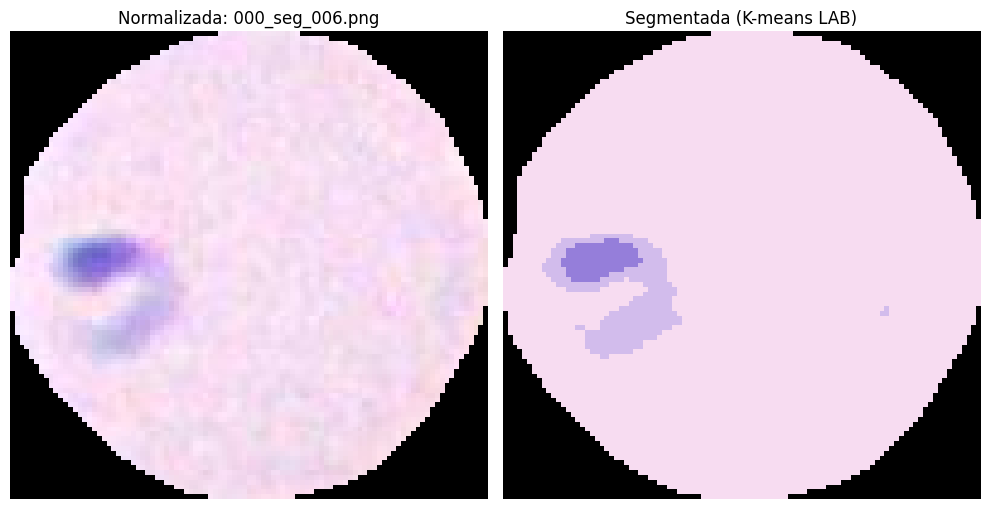

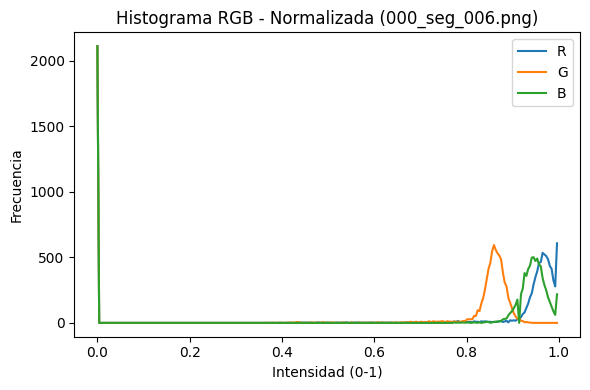

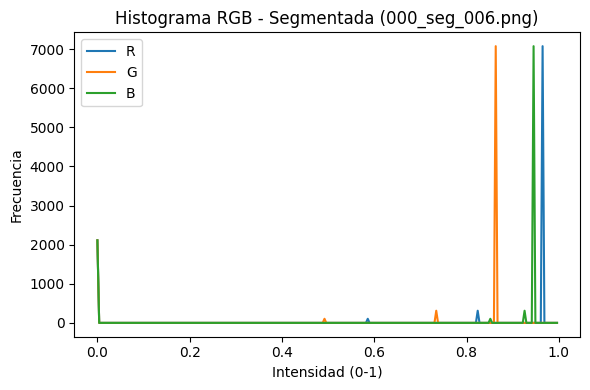

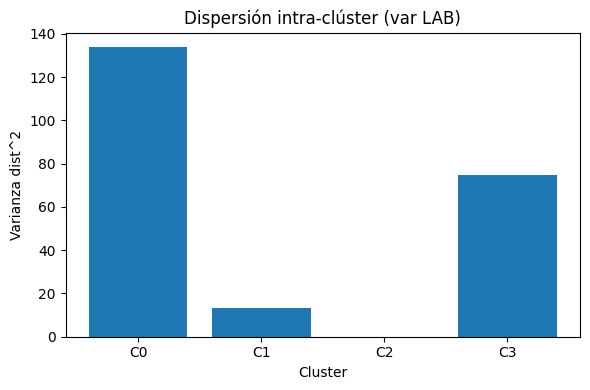

000_seg_005.png: pixeles=[5404, 2369, 131, 3004], dispersion=[12.515769958496094, 10.605039596557617, 267.13958740234375, 0.0]


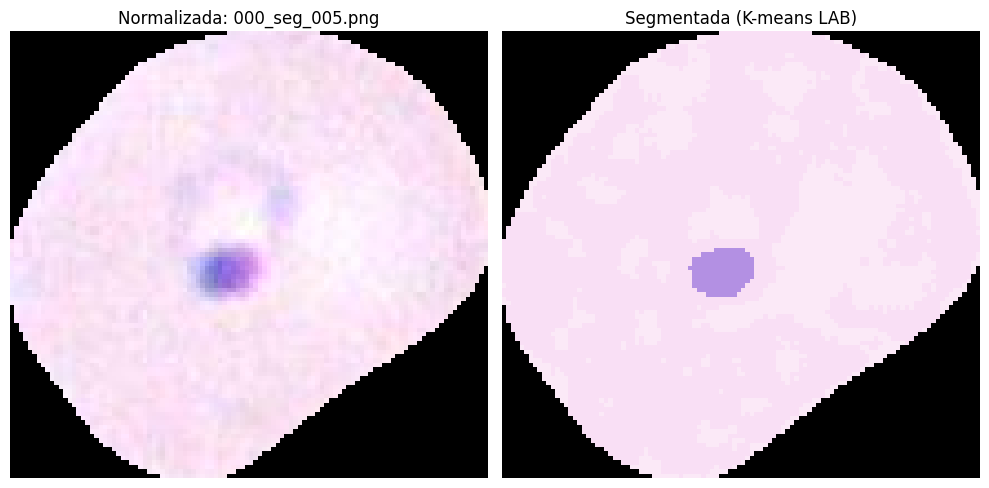

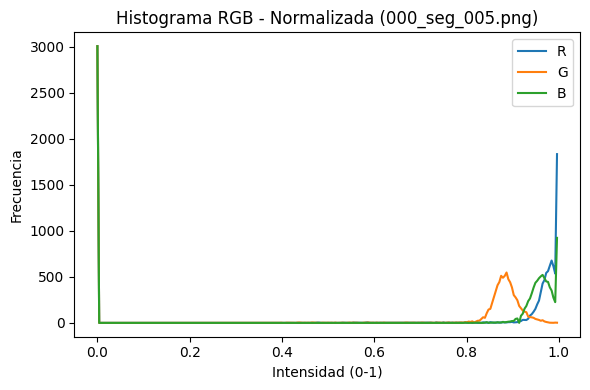

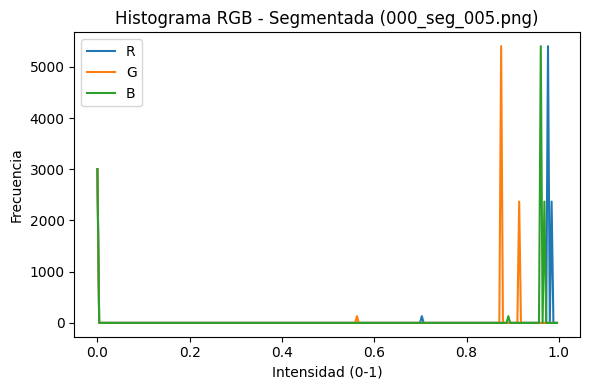

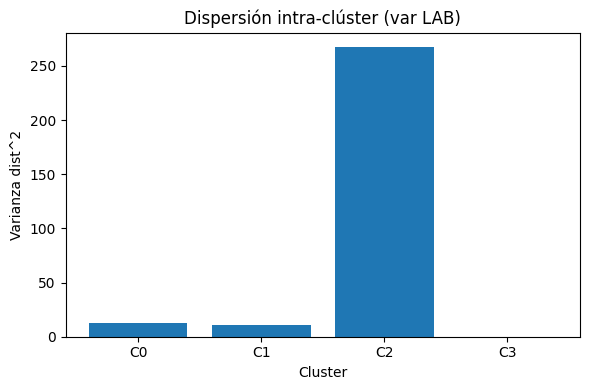

000_seg_002.png: pixeles=[146, 2858, 6769, 787], dispersion=[124.291259765625, 0.0, 11.677048683166504, 36.14942169189453]


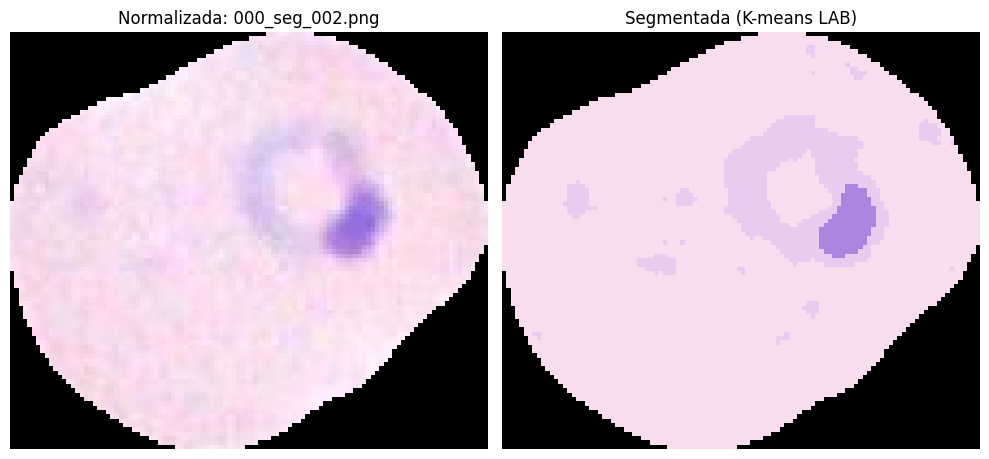

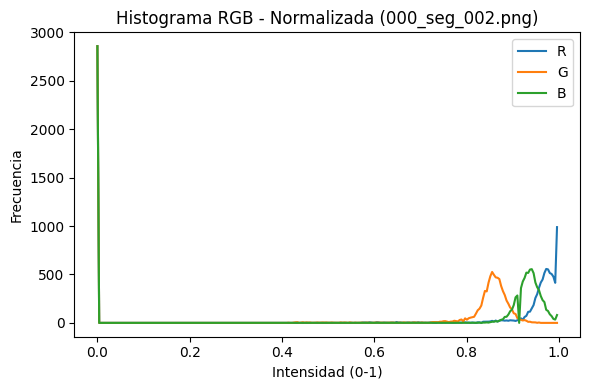

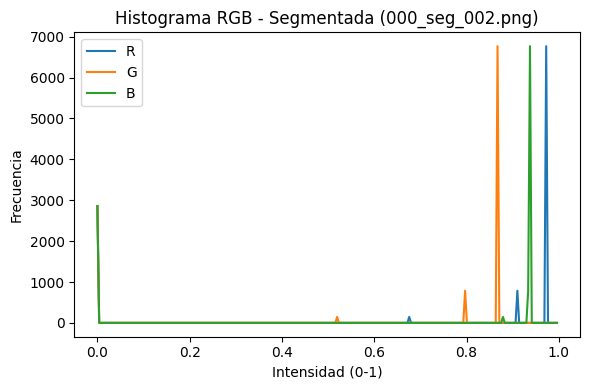

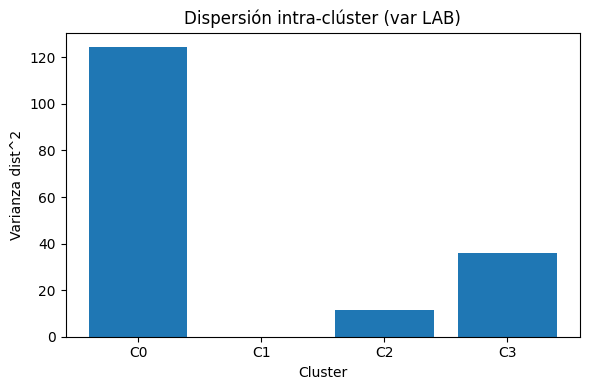


Resultados guardados en: img/resumen_clusters.csv


In [13]:
from pathlib import Path
import numpy as np
import cv2
from skimage import color as skcolor, img_as_ubyte
import matplotlib.pyplot as plt
import pandas as pd

# =============== Utilidades ===============

def read_rgb_float01(path: str):
    """cv2.imread -> RGB float32 en [0,1]"""
    arr = cv2.imread(path, cv2.IMREAD_COLOR)
    if arr is None:
        raise FileNotFoundError(f"No se puede leer: {path}")
    arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
    return (arr.astype(np.float32) / 255.0)

def normalize_img(img: np.ndarray, rimg: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    """Normaliza por imagen de referencia, resultado en [0,1]."""
    norm = img / (rimg + eps)
    norm = np.nan_to_num(norm, nan=0.0, posinf=0.0, neginf=0.0)
    return np.clip(norm, 0.0, 1.0).astype(np.float32)

def kmeans_lab_segments(rgb_float: np.ndarray, K: int = 4, max_iter: int = 60, attempts: int = 20):
    """RGB[0,1] -> LAB, k-means en LAB"""
    lab = skcolor.rgb2lab(rgb_float)
    h, w, _ = lab.shape
    samples = lab.reshape((-1, 3)).astype(np.float32)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iter, 1.0)
    compactness, labels, centers = cv2.kmeans(
        samples, K, None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS
    )
    labels = labels.flatten()
    segmented_lab = centers[labels].reshape((h, w, 3))
    return labels, centers, segmented_lab, lab

def plot_rgb_histogram(img, title="Histograma RGB"):
    """Histogramas de los 3 canales RGB"""
    plt.figure(figsize=(6,4))
    for i, name in enumerate(("R","G","B")):
        hist, bins = np.histogram(img[:,:,i].ravel(), bins=256, range=(0,1))
        plt.plot(bins[:-1], hist, label=name)
    plt.title(title)
    plt.xlabel("Intensidad (0-1)")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.tight_layout()
    plt.show()

def cluster_dispersion(lab_image, labels, centers):
    """Varianza intra-clúster en LAB"""
    X = lab_image.reshape((-1,3))
    dispersions = []
    for k in range(centers.shape[0]):
        pts = X[labels == k]
        if pts.shape[0] == 0:
            dispersions.append(np.nan)
        else:
            d2 = np.sum((pts - centers[k])**2, axis=1)
            dispersions.append(float(np.mean(d2)))
    return dispersions

# =============== Configuración ===============
root = "./img"     # cambia si es necesario
K = 4
save_dir = Path(root)
csv_path = Path(root) / "resumen_clusters.csv"

# Buscar pares *_ref.png
pairs = []
for ref_path in Path(root).rglob("*_ref.png"):
    img_path = Path(str(ref_path).replace("_ref.png", ".png"))
    if img_path.exists():
        pairs.append((img_path, ref_path))

print(f"Pares encontrados: {len(pairs)}")
if len(pairs) == 0:
    print("No se encontraron pares. Revisa rutas.")

# DataFrame para resultados
df_results = []

# =============== Proceso por imagen ===============
for (img_path, ref_path) in pairs:
    img  = read_rgb_float01(str(img_path))
    rimg = read_rgb_float01(str(ref_path))
    norm_img = normalize_img(img, rimg)

    labels, centers, seg_lab, lab_img = kmeans_lab_segments(norm_img, K=K)
    seg_rgb = skcolor.lab2rgb(seg_lab)

    # Conteos y dispersión
    counts = np.bincount(labels, minlength=centers.shape[0]).astype(int).tolist()
    disp = cluster_dispersion(lab_img, labels, centers)

    # Guardar segmentación
    out_path = save_dir / f"{img_path.stem}_seg.png"
    cv2.imwrite(str(out_path), cv2.cvtColor(img_as_ubyte(seg_rgb), cv2.COLOR_RGB2BGR))

    # Consola
    print(f"{img_path.name}: pixeles={counts}, dispersion={disp}")

    # Guardar en lista para DataFrame
    for k_idx in range(len(counts)):
        df_results.append({
            "imagen": img_path.name,
            "cluster": k_idx,
            "pixeles": counts[k_idx],
            "dispersion_var_LAB": disp[k_idx]
        })

    # Mostrar imágenes
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(norm_img)
    plt.title(f"Normalizada: {img_path.name}")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(seg_rgb)
    plt.title("Segmentada (K-means LAB)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Histogramas
    plot_rgb_histogram(norm_img, f"Histograma RGB - Normalizada ({img_path.name})")
    plot_rgb_histogram(seg_rgb,  f"Histograma RGB - Segmentada ({img_path.name})")

    # Dispersión en gráfico de barras
    plt.figure(figsize=(6,4))
    x = np.arange(len(disp))
    plt.bar(x, disp)
    plt.xticks(x, [f"C{k}" for k in range(len(disp))])
    plt.title("Dispersión intra-clúster (var LAB)")
    plt.xlabel("Cluster")
    plt.ylabel("Varianza dist^2")
    plt.tight_layout()
    plt.show()

# Crear DataFrame y exportar
df = pd.DataFrame(df_results)
df.to_csv(csv_path, index=False)
print(f"\nResultados guardados en: {csv_path}")

In [14]:
df

,imagen,cluster,pixeles,dispersion_var_LAB
0,000_seg_003.png,0,7507,14.146590
1,000_seg_003.png,1,1079,47.070400
2,000_seg_003.png,2,2428,0.000000
3,000_seg_003.png,3,286,161.699539
4,000_seg_004.png,0,630,42.078083
5,000_seg_004.png,1,147,64.816841
6,000_seg_004.png,2,2794,0.000000
7,000_seg_004.png,3,6879,13.624306
8,000_seg_000.png,0,827,71.765900
9,000_seg_000.png,1,2000,0.000000
